In [1]:
def get_query(cursor, first, season, strength):
    cursor_filter = "(after: \"{}\", first: {})".format(cursor, first) if cursor is not None else ""
    strength_filter = "strength: {}".format(strength) if strength is not None else ""
    shots_filter = "(filter: {%s})" % strength_filter if strength is not None else ""
    season_filter = "(filter: {id: \"%s\" })" % season

    return """
    {
      seasons%s {
        shots%s {
          fenwickEvents%s {
            total
            pageInfo {
              startCursor
              endCursor
              hasNextPage
            }
            edges {
              node {
                type
                period
                homeGame
                coordX
                coordY
                angle
                distance
                shotType
                event
                priorEvent
                team
                priorEventTeam
                angleChange
                distanceChange
                leading
                leadingByOne
                trailing
                trailingByOne
                secondsChange
              }
            }
          }
        }
      }
    }
    """ % (season_filter, shots_filter, cursor_filter)
    
print(get_query(cursor=None, first=10000, season='20102011', strength='EVENSTRENGTH'))


    {
      seasons(filter: {id: "20102011" }) {
        shots(filter: {strength: EVENSTRENGTH}) {
          fenwickEvents {
            total
            pageInfo {
              startCursor
              endCursor
              hasNextPage
            }
            edges {
              node {
                type
                period
                homeGame
                coordX
                coordY
                angle
                distance
                shotType
                event
                priorEvent
                team
                priorEventTeam
                angleChange
                distanceChange
                leading
                leadingByOne
                trailing
                trailingByOne
                secondsChange
              }
            }
          }
        }
      }
    }
    


In [2]:
def get_shots(url, cursor, first, season, strength):
    response = requests.post(url, json={'query': get_query(cursor=cursor, first=first, season=season,strength=strength)})
    json_data = json.loads(response.text)
    total = json_data['data']['seasons'][0]['shots']['fenwickEvents']['total']
    has_next_page = json_data['data']['seasons'][0]['shots']['fenwickEvents']['pageInfo']['hasNextPage']
    cursor = json_data['data']['seasons'][0]['shots']['fenwickEvents']['pageInfo']['endCursor']
    df_data = json_data['data']['seasons'][0]['shots']['fenwickEvents']['edges']
    df_data = list(map(lambda edge: edge['node'], df_data))
    df = pd.DataFrame(df_data)

    return df, total, has_next_page, cursor

In [3]:
import requests
import json
import pandas as pd
from tqdm import tqdm

first = 5000
strength = 'EVENSTRENGTH'
url = "http://localhost:4000/"

seasons = ["20102011", "20112012", "20122013", "20132014", "20142015", "20152016", "20162017", "20172018", "20182019", "20192020"]
df = pd.DataFrame()

for season in seasons:
    print(f'Grabbing data for {season}')
    df_season, total, has_next_page, cursor = get_shots(url, None, first, season, strength)

    pbar = tqdm(total=total)

    while has_next_page is True:
        df_new, total, has_next_page, cursor = get_shots(url, cursor, first, season, strength)
        df_season = df_season.append(df_new)

        pbar.update(len(df_new))

    pbar.close()
    df = df.append(df_season)

Grabbing data for 20102011
100%|█████████▉| 64011/64111 [00:28<00:00, 2273.92it/s]
Grabbing data for 20112012
100%|█████████▉| 63841/63941 [00:29<00:00, 2197.03it/s]
Grabbing data for 20122013
100%|█████████▉| 38894/38994 [00:12<00:00, 3116.26it/s]
Grabbing data for 20132014
100%|█████████▉| 64790/64890 [00:29<00:00, 2229.78it/s]
Grabbing data for 20142015
100%|█████████▉| 66179/66279 [00:31<00:00, 2100.49it/s]
Grabbing data for 20152016
100%|█████████▉| 65346/65446 [00:32<00:00, 2039.69it/s]
Grabbing data for 20162017
100%|█████████▉| 66862/66962 [00:31<00:00, 2146.80it/s]
Grabbing data for 20172018
100%|█████████▉| 71801/71901 [00:35<00:00, 2005.55it/s]
Grabbing data for 20182019
100%|█████████▉| 71722/71822 [00:33<00:00, 2136.30it/s]
Grabbing data for 20192020
100%|█████████▉| 56780/56880 [00:24<00:00, 2313.76it/s]


In [28]:
import numpy as np

df['priorEventShot'] = df['priorEvent'] == "SHOT"
df['priorEventSameTeam'] = df['priorEventTeam'] == df['team']
df['snapShot'] = df['shotType'] == "SNAP SHOT"
df['wristShot'] = df['shotType'] == "WRIST SHOT"
df['slapShot'] = df['shotType'] == "SLAP SHOT"
df['deflected'] = df['shotType'] == "DEFLECTED"
df['backhand'] = df['shotType'] == "BACKHAND"
df['wrapAround'] = df['shotType'] == "WRAP-AROUND"
df['tipIn'] = df['shotType'] == "TIP-IN"
df['goal'] = df['type'] == 'GOAL'
df = df.dropna()

feature_names = ['priorEventShot', 'priorEventSameTeam', 'coordX', 'coordY', 'angle', 'distance', 'snapShot', 'wristShot', 'slapShot', 'deflected', 'backhand', 'wrapAround', 'tipIn', 'angleChange', 'distanceChange', 'leading', 'leadingByOne', 'trailing', 'trailingByOne', 'secondsChange']

inputs = df[feature_names].dropna().to_numpy().astype('float32')
outputs = df[['goal']].to_numpy().flatten().astype('float32')

print(feature_names)
print(np.isnan(inputs).any())
print(np.isnan(outputs).any())
print(len(inputs))

['priorEventShot', 'priorEventSameTeam', 'coordX', 'coordY', 'angle', 'distance', 'snapShot', 'wristShot', 'slapShot', 'deflected', 'backhand', 'wrapAround', 'tipIn', 'angleChange', 'distanceChange', 'leading', 'leadingByOne', 'trailing', 'trailingByOne', 'secondsChange']
False
False
623532


In [29]:
def normalize(inputs):
    inputs_min = np.min(inputs, axis=0)
    inputs_max = np.max(inputs, axis=0)

    return (inputs - inputs_min) / (inputs_max - inputs_min)


In [30]:
# inputs = normalize(inputs)

features_length = len(np.array(inputs)[0, :])
inputs_train_length = np.ceil(len(inputs[:, 0]) * 0.9).astype('int')
inputs_train = inputs[0 : inputs_train_length]
inputs_test = inputs[inputs_train_length :]

outputs_train = outputs[0 : inputs_train_length]
outputs_test = outputs[inputs_train_length :]

# print(len(outputs_test))
# print(inputs)
# print(np.mean(inputs, axis=0))
# print(np.var(inputs, axis=0))

In [38]:
import time
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.layers.advanced_activations import LeakyReLU

from keras.losses import BinaryCrossentropy
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

model_file = 'test.h5'

layers = [features_length, features_length * 5, 1]
epochs = 200
batch_size = 100

def build_model():
    model = Sequential()

    model.add(Dense(
        layers[1],
        input_dim = layers[0],
        activation=LeakyReLU(alpha=0.3),
        # kernel_regularizer = regularizers.l2(0.001)
    ))

    # model.add(Dropout(0.2))

    # model.add(Dense(
    #     layers[1],
    #     activation="relu"
    # ))

    # model.add(Dropout(0.2))

    model.add(Dense(
        layers[2],
        activation="sigmoid"
    ))

    start = time.time()

    # optimizer = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])
    print("> Compilation Time : ", time.time() - start)
    return model

def train_model(model_file, epochs, layers, batch_size):
    global_start_time = time.time()

    # tensorboard = TensorBoard(log_dir="logs/"+ str(global_start_time),
    #     histogram_freq=5,
    #     write_graph= True,
    #     write_grads = True)

    model = KerasRegressor(build_model, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    history = model.fit(inputs_train, outputs_train)

    #model = build_model()
    #history= model.fit(inputs_train, outputs_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)
    
    # kfold = StratifiedKFold(n_splits=10, shuffle=True)
    # results = cross_val_score(model, inputs_train, outputs_train, cv=kfold)

    
    #model.save(model_file)

    print('Training duration (s) : ', time.time() - global_start_time)

    return [model, history]

[model, history] = train_model(model_file, epochs, layers, batch_size)

# layer = model.get_layer(index=0)
# weights = layer.get_weights()

 val_loss: 0.2803 - val_accuracy: 0.9108
Epoch 66/200
5051/5051 [==============================] - 5s 951us/step - loss: 0.2612 - accuracy: 0.9137 - val_loss: 0.2706 - val_accuracy: 0.9108
Epoch 67/200
5051/5051 [==============================] - 5s 955us/step - loss: 0.2613 - accuracy: 0.9137 - val_loss: 0.2712 - val_accuracy: 0.9107
Epoch 68/200
5051/5051 [==============================] - 5s 941us/step - loss: 0.2612 - accuracy: 0.9136 - val_loss: 0.2710 - val_accuracy: 0.9107
Epoch 69/200
5051/5051 [==============================] - 5s 924us/step - loss: 0.2613 - accuracy: 0.9137 - val_loss: 0.2723 - val_accuracy: 0.9108
Epoch 70/200
5051/5051 [==============================] - 5s 915us/step - loss: 0.2612 - accuracy: 0.9137 - val_loss: 0.2730 - val_accuracy: 0.9108
Epoch 71/200
5051/5051 [==============================] - 5s 923us/step - loss: 0.2611 - accuracy: 0.9137 - val_loss: 0.2716 - val_accuracy: 0.9107
Epoch 72/200
5051/5051 [==============================] - 5s 947us/step

In [39]:
predictions = model.predict(inputs_test)

print(predictions)
print(np.max(predictions))
print(np.sum(outputs_test))

[0.09032688 0.1797958  0.08028036 ... 0.12745285 0.16610664 0.08037022]
0.6433032
5580.0


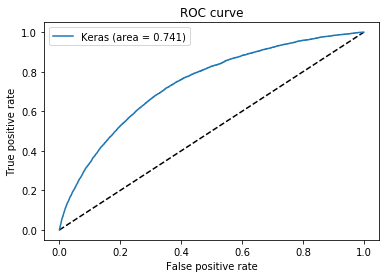

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

predictions = model.predict(inputs_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(outputs_test, predictions)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [41]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(inputs_test, outputs_test)
eli5.show_weights(perm, feature_names = feature_names)

624/624 [==============================] - 0s 698us/step - loss: 0.2810 - accuracy: 0.9101


Weight,Feature
0.0389 ± 0.0012,distance
0.0104 ± 0.0006,secondsChange
0.0084 ± 0.0007,coordX
0.0037 ± 0.0002,backhand
0.0031 ± 0.0003,wristShot
0.0019 ± 0.0003,wrapAround
0.0017 ± 0.0003,leading
0.0017 ± 0.0003,distanceChange
0.0014 ± 0.0003,angleChange
0.0010 ± 0.0002,angle


In [27]:
xl

,type,period,homeGame,coordX,coordY,angle,distance,shotType,event,priorEvent,...,priorEventShot,priorEventSameTeam,snapShot,wristShot,slapShot,deflected,backhand,wrapAround,tipIn,goal
1,SHOTONGOAL,1,False,83.0,-5.0,9.281799,31.0,SNAP SHOT,SHOTONGOAL,SHOT,...,False,True,True,False,False,False,False,False,False,False
3,SHOTONGOAL,1,True,-81.0,9.0,5.803876,89.0,WRIST SHOT,SHOTONGOAL,SHOT,...,False,True,False,True,False,False,False,False,False,False
19,SHOTONGOAL,2,True,61.0,29.0,1.912412,869.0,WRIST SHOT,SHOTONGOAL,SHOT,...,False,False,False,True,False,False,False,False,False,False
26,SHOTONGOAL,2,False,-83.0,-17.0,3.303621,295.0,SNAP SHOT,SHOTONGOAL,SHOT,...,False,True,True,False,False,False,False,False,False,False
27,SHOTONGOAL,2,True,57.0,-37.0,1.513341,1401.0,WRIST SHOT,SHOTONGOAL,SHOT,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,SHOTONGOAL,2,False,78.0,-6.0,7.334369,47.0,BACKHAND,SHOTONGOAL,SHOT,...,False,True,False,False,False,False,True,False,False,False
1754,SHOTONGOAL,2,False,74.0,-13.0,4.051447,184.0,SNAP SHOT,SHOTONGOAL,SHOT,...,False,True,True,False,False,False,False,False,False,False
1766,SHOTONGOAL,2,False,53.0,4.0,4.411726,52.0,SLAP SHOT,SHOTONGOAL,SHOT,...,False,True,False,False,True,False,False,False,False,False
1772,SHOTONGOAL,3,False,-72.0,-17.0,3.184739,306.0,SLAP SHOT,SHOTONGOAL,SHOT,...,False,False,False,False,True,False,False,False,False,False
